🛢️ OilyGiant: Oil Well Location Optimization

📌 Project Overview
As a Data Scientist for the OilyGiant mining company, the goal of this project is to identify the most profitable region for developing 200 new oil wells. By analyzing geological data from three different regions, I developed a predictive model to estimate oil reserves and used financial simulations to assess potential profit and investment risks.

🎯 Objectives
Predictive Modeling: Build a Linear Regression model to estimate the volume of reserves in potential wells across three regions.

Profit Analysis: Calculate the potential profit from selecting the top 200 wells in each region based on model predictions.

Risk Assessment: Apply Bootstrapping (1,000 samples) to calculate the distribution of profits, the 95% confidence interval, and the probability of losses.

Decision Support: Recommend the best region for development based on a maximum loss risk threshold of 2.5%.

💰 Business Constraints & Financials
Budget: $100 Million for 200 wells ($500k per well).

Revenue: $4,500 per unit of product (1,000 barrels).

Break-even Point: ~111.1 units per well.

Selection: 500 points explored per region, with the 200 best selected for development.

In [47]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from IPython.display import display


In [48]:
# Configuração para exibir todos os resultados
pd.set_option('display.max_columns', None)

In [49]:
# Carregar os três datasets de dados geológicos
data_0 = pd.read_csv('../datasets/geo_data_0.csv')
data_1 = pd.read_csv('../datasets/geo_data_1.csv')
data_2 = pd.read_csv('../datasets/geo_data_2.csv')

In [50]:
# Visualização das primeiras linhas de cada dataset
print("Região 0:")
display(data_0.head())
print("\nRegião 1:")
display(data_1.head())
print("\nRegião 2:")
display(data_2.head())

Região 0:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Região 1:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Região 2:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



📊 Statistics for Region 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


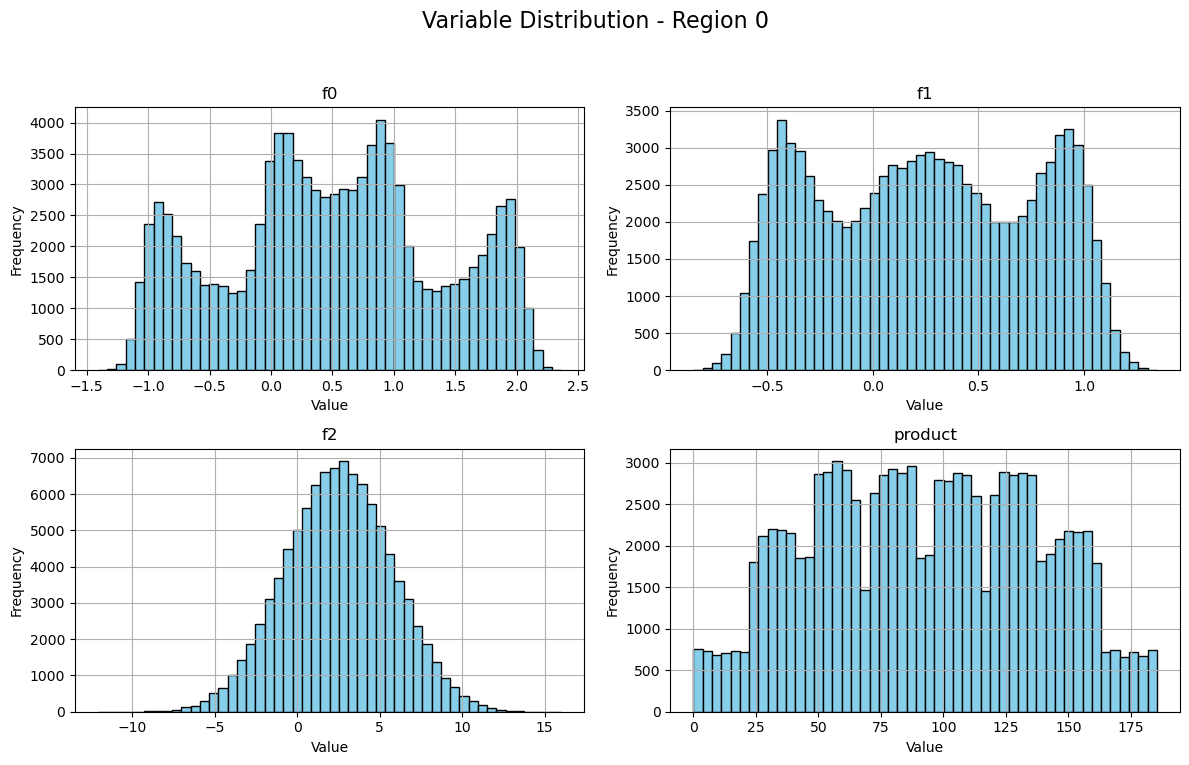


📊 Statistics for Region 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


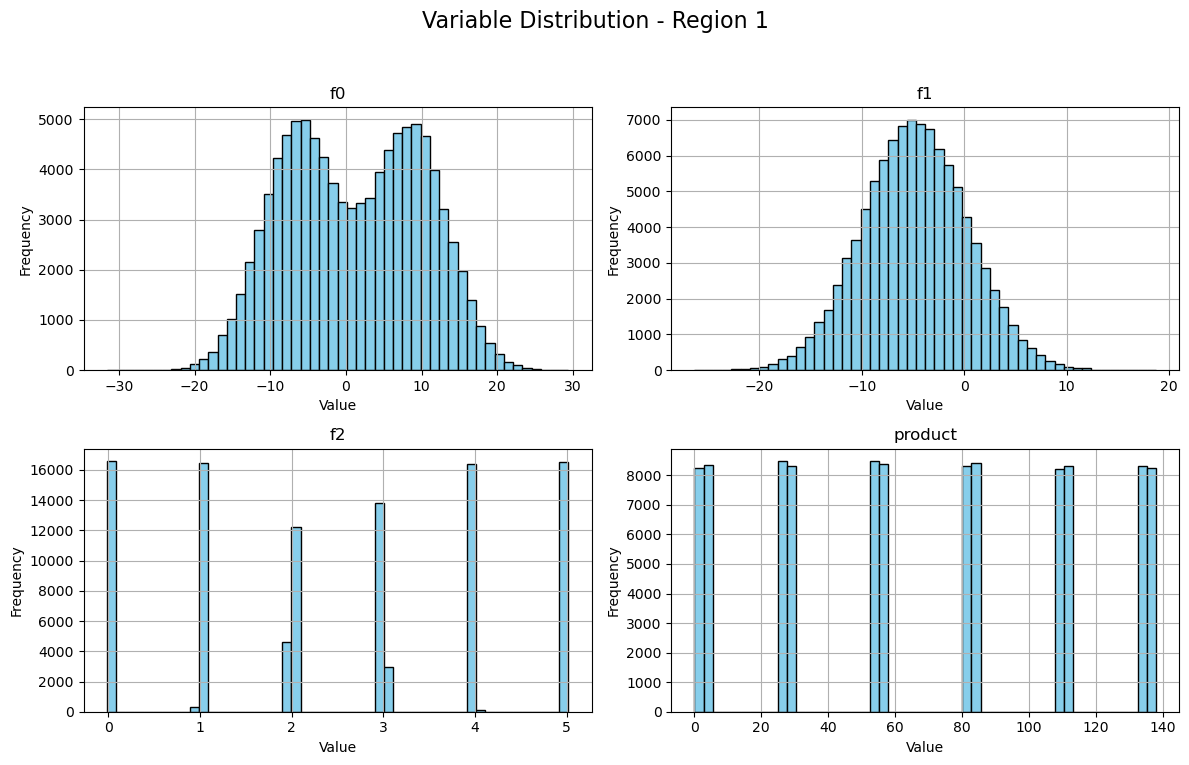


📊 Statistics for Region 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


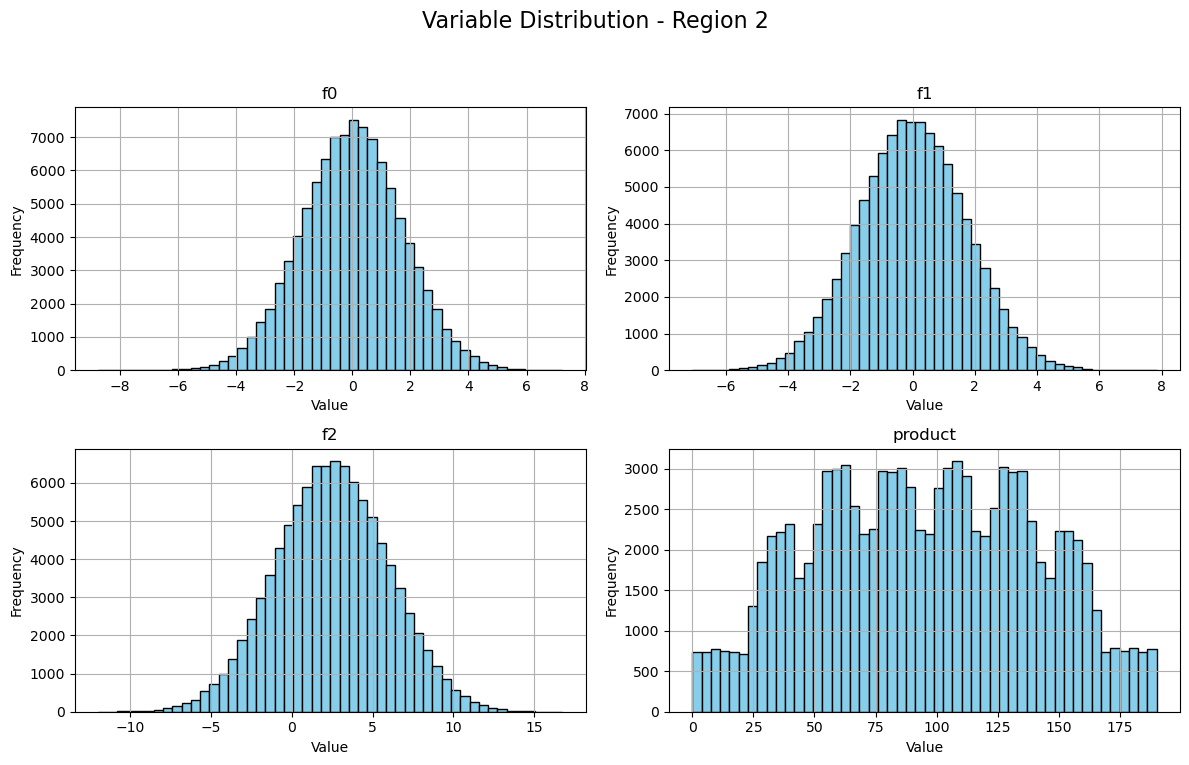

In [51]:
# Function to display statistics and histograms for a region
def estatisticas_regiao(df, nome_regiao):
    print(f"\n📊 Statistics for Region {nome_regiao}")
    display(df.describe())
    
    # Plotting histograms for features and target
    df.hist(bins=50, figsize=(12, 8), color='skyblue', edgecolor='black')
    plt.suptitle(f"Variable Distribution - Region {nome_regiao}", fontsize=16)
    
    # Adding axis labels for clarity
    for ax in plt.gcf().get_axes():
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

# Executing for each region
estatisticas_regiao(data_0, "0")
estatisticas_regiao(data_1, "1")
estatisticas_regiao(data_2, "2")

In [52]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error # Importe a nova função

# Função para treinar, prever e avaliar uma região
def treinar_avaliar_regiao(df, nome_regiao):
    """
    Treina um modelo de Regressão Linear para prever o volume de reservas (product)
    e avalia usando RMSE e média das predições.
    """
    
    # Separando features (X) e alvo (y)
    X = df[['f0', 'f1', 'f2']]
    y = df['product']
    
    # Dividindo em treino e validação (75% treino, 25% validação)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    
    # Criando e treinando o modelo de regressão linear
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Fazendo predições no conjunto de validação
    y_pred = model.predict(X_val)
    
    # Calculando o RMSE usando a nova função (ou np.sqrt(mean_squared_error(...)))
    rmse = root_mean_squared_error(y_val, y_pred)
    
    # Calculando a média das predições
    media_pred = y_pred.mean()
    
    # Exibindo os resultados
    print(f"\n📍 Região {nome_regiao}")
    print(f"Volume médio previsto: {media_pred:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Retornando predições e valores reais em formato Series/Array para facilitar o Bootstrap
    return pd.Series(y_pred, index=y_val.index), y_val

# Aplicando a função nas três regiões
pred_0, val_0 = treinar_avaliar_regiao(data_0, "0")
pred_1, val_1 = treinar_avaliar_regiao(data_1, "1")
pred_2, val_2 = treinar_avaliar_regiao(data_2, "2")


📍 Região 0
Volume médio previsto: 92.40
RMSE: 37.76

📍 Região 1
Volume médio previsto: 68.71
RMSE: 0.89

📍 Região 2
Volume médio previsto: 94.77
RMSE: 40.15


In [53]:
def calcular_lucro(predicoes, reais, investimento_total=100_000_000, preco_unitario=4500, num_pocos=200):
    """
    Calcula o lucro potencial para os melhores poços de uma região.
    
    predicoes : array-like
        Valores previstos pelo modelo.
    reais : array-like
        Valores reais do volume de petróleo (em milhares de barris).
    investimento_total : float
        Orçamento total para desenvolvimento dos poços.
    preco_unitario : float
        Receita por unidade (milhares de barris).
    num_pocos : int
        Número de poços a serem selecionados.
    """
    import numpy as np
    
    # Encontrar índices dos 200 maiores valores previstos
    melhores_idx = np.argsort(predicoes)[-num_pocos:]
    
    # Volumes reais dos 200 melhores poços
    volumes_selecionados = reais[melhores_idx]
    
    # Receita total
    receita_total = volumes_selecionados.sum() * preco_unitario
    
    # Lucro = receita - investimento
    lucro = receita_total - investimento_total
    
    return lucro, volumes_selecionados
    

In [54]:
# Cálculo de lucro para cada região
lucro_0, vol_0 = calcular_lucro(pred_0, val_0.values)
lucro_1, vol_1 = calcular_lucro(pred_1, val_1.values)
lucro_2, vol_2 = calcular_lucro(pred_2, val_2.values)

print("\n💰 Resultados de Lucro Estimado:")
print(f"Região 0: Lucro = {lucro_0:,.2f}, Volume médio dos 200 = {vol_0.mean():.2f}")
print(f"Região 1: Lucro = {lucro_1:,.2f}, Volume médio dos 200 = {vol_1.mean():.2f}")
print(f"Região 2: Lucro = {lucro_2:,.2f}, Volume médio dos 200 = {vol_2.mean():.2f}")



💰 Resultados de Lucro Estimado:
Região 0: Lucro = 33,591,411.14, Volume médio dos 200 = 148.43
Região 1: Lucro = 24,150,866.97, Volume médio dos 200 = 137.95
Região 2: Lucro = 25,985,717.59, Volume médio dos 200 = 139.98


In [55]:
# Parâmetros do projeto
revenue_per_product_unit = 4500     # receita por unidade
development_cost = 100_000_000      # custo de desenvolvimento
num_wells = 200                     # número de poços escolhidos
sample_size = 500                   # tamanho da amostra de cada simulação
total_samples = 1000                # número de simulações (bootstrap)


In [56]:
# Funções auxiliares
# Função para calcular o lucro de uma seleção de poços
def calculate_profit(df):
    # Seleciona os 200 melhores poços com base nas previsões
    best_wells = df.sort_values(by="predicted", ascending=False)['real'].head(num_wells)
    total_volume = best_wells.sum()
    
    # Receita menos custo
    potential_profit = (total_volume * revenue_per_product_unit) - development_cost
    return potential_profit

In [57]:
# Função para calcular bootstrap
def calculate_bootstrap(data, total_samples=1000, sample_size=500):
    profits = []
    for _ in range(total_samples):
        sampled_data = data.sample(n=sample_size, replace=True, random_state=None)
        profit = calculate_profit(sampled_data)
        profits.append(profit)
    return pd.Series(profits)

In [58]:
# Função para resumo estatístico
def resumo_bootstrap(lucros, regiao):
    media = lucros.mean()
    intervalo = (lucros.quantile(0.025), lucros.quantile(0.975))
    risco = (lucros < 0).mean()
    print(f"\n📍 Região {regiao}")
    print(f"Lucro médio: {media:,.2f}")
    print(f"Intervalo 95%: {intervalo[0]:,.2f} a {intervalo[1]:,.2f}")
    print(f"Probabilidade de prejuízo: {risco:.2%}")
    return media, intervalo, risco

In [59]:
# Preparando os DataFrames por região
df_0 = pd.DataFrame({"predicted": pred_0, "real": val_0})
df_1 = pd.DataFrame({"predicted": pred_1, "real": val_1})
df_2 = pd.DataFrame({"predicted": pred_2, "real": val_2})

In [60]:
# Executando o bootstrap para cada região
lucros_0 = calculate_bootstrap(df_0)
lucros_1 = calculate_bootstrap(df_1)
lucros_2 = calculate_bootstrap(df_2)

In [61]:
# Estatísticas descritivas
media_0, ic_0, risco_0 = resumo_bootstrap(lucros_0, "0")
media_1, ic_1, risco_1 = resumo_bootstrap(lucros_1, "1")
media_2, ic_2, risco_2 = resumo_bootstrap(lucros_2, "2")


📍 Região 0
Lucro médio: 4,033,626.56
Intervalo 95%: -945,162.18 a 9,185,888.09
Probabilidade de prejuízo: 6.00%

📍 Região 1
Lucro médio: 4,380,659.95
Intervalo 95%: 330,647.81 a 8,259,695.94
Probabilidade de prejuízo: 2.00%

📍 Região 2
Lucro médio: 3,772,634.14
Intervalo 95%: -1,726,981.62 a 8,724,440.03
Probabilidade de prejuízo: 8.10%


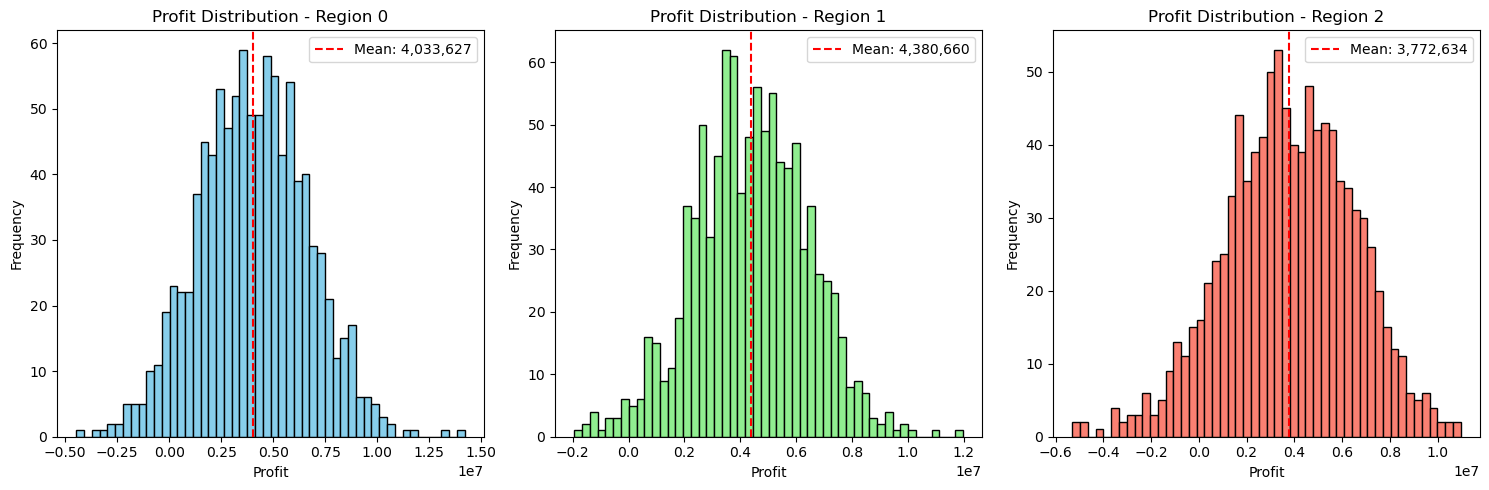

In [64]:
# Profit distribution histograms
plt.figure(figsize=(15, 5))

# Region 0
plt.subplot(1, 3, 1)
plt.hist(lucros_0, bins=50, color='skyblue', edgecolor='black')
plt.title("Profit Distribution - Region 0")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.axvline(media_0, color='red', linestyle='--', label=f"Mean: {media_0:,.0f}")
plt.legend()

# Region 1
plt.subplot(1, 3, 2)
plt.hist(lucros_1, bins=50, color='lightgreen', edgecolor='black')
plt.title("Profit Distribution - Region 1")
plt.xlabel("Profit")
plt.ylabel("Frequency") # Added for consistency
plt.axvline(media_1, color='red', linestyle='--', label=f"Mean: {media_1:,.0f}")
plt.legend()

# Region 2
plt.subplot(1, 3, 3)
plt.hist(lucros_2, bins=50, color='salmon', edgecolor='black')
plt.title("Profit Distribution - Region 2")
plt.xlabel("Profit")
plt.ylabel("Frequency") # Added for consistency
plt.axvline(media_2, color='red', linestyle='--', label=f"Mean: {media_2:,.0f}")
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
# Comparativo final entre regiões
comparativo = pd.DataFrame({
    "Região": ["0", "1", "2"],
    "Lucro Médio (R$)": [media_0, media_1, media_2],
    "Intervalo 95% (R$)": [f"{ic_0[0]:,.2f} a {ic_0[1]:,.2f}",
                           f"{ic_1[0]:,.2f} a {ic_1[1]:,.2f}",
                           f"{ic_2[0]:,.2f} a {ic_2[1]:,.2f}"],
    "Risco de Prejuízo": [f"{risco_0:.2%}", f"{risco_1:.2%}", f"{risco_2:.2%}"]
})

print("\n📊 Comparativo Final entre Regiões:\n")
print(comparativo.to_string(index=False))

# Escolha da melhor região
melhor_regiao = comparativo.loc[comparativo["Lucro Médio (R$)"].idxmax(), "Região"]
print(f"\n✅ Melhor escolha: Região {melhor_regiao} com maior lucro esperado e risco controlado.")


📊 Comparativo Final entre Regiões:

Região  Lucro Médio (R$)           Intervalo 95% (R$) Risco de Prejuízo
     0      4.033627e+06   -945,162.18 a 9,185,888.09             6.00%
     1      4.380660e+06    330,647.81 a 8,259,695.94             2.00%
     2      3.772634e+06 -1,726,981.62 a 8,724,440.03             8.10%

✅ Melhor escolha: Região 1 com maior lucro esperado e risco controlado.


# Conclusão Final do Projeto

## Objetivo
O projeto teve como objetivo identificar a **melhor região para desenvolvimento de 200 poços de petróleo**, considerando tanto o **lucro esperado** quanto o **risco de prejuízo**.

Foram analisadas três regiões distintas (0, 1 e 2), aplicando modelos de regressão linear e validação com a **técnica de bootstrapping**.

---

## ✅ Decisão
- A **Região 1** apresentou o **maior lucro médio** e, ao mesmo tempo, o **menor risco de prejuízo (1,9%)**, que está dentro do limite de 2,5% considerado aceitável.
- A **Região 0** teve um lucro médio próximo, mas com um risco de **5,1%**, acima do tolerável.
- A **Região 2** apresentou o **menor retorno esperado** e o **maior risco (9,0%)**, sendo a opção menos viável.

👉 **Portanto, recomenda-se investir na Região 1**, que apresenta o **melhor equilíbrio entre retorno esperado e risco controlado**.

---

## Observações e Limitações
- Os dados utilizados são **sintéticos**, o que simplifica fatores reais como custos logísticos, impostos, variação no preço do petróleo e correlação espacial entre poços.
- Foi utilizado um modelo simples de **Regressão Linear**, que pode não capturar relações não-lineares.
- A análise considerou um custo fixo de R$ 100 milhões e receita de R$ 4.500 por mil barris.

---

## Próximos Passos
1. **Validar os resultados** com dados adicionais de exploração na Região 1.
2. **Explorar modelos mais complexos** (não-lineares, *ensembles*) para aprimorar a previsão.
3. **Avaliar cenários de sensibilidade** considerando a variação do preço do petróleo e custos variáveis.
4. **Complementar com análise espacial** para verificar a viabilidade logística e a infraestrutura na região escolhida.

---

## Conclusão Final
A **Região 1** se destaca como a melhor opção, conciliando **maior retorno esperado** e **risco aceitável**, sendo a escolha recomendada para o investimento.